# Import

In [1]:
import xdas as xd
import numpy as np
import scipy.signal as sp
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates

In [2]:
# -- Axes --
plt.rcParams["axes.spines.bottom"] = True
plt.rcParams["axes.spines.left"] = True
plt.rcParams["axes.spines.right"] = True
plt.rcParams["axes.spines.top"] = True
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["axes.axisbelow"] = False
plt.rcParams["axes.linewidth"] = 1
plt.rcParams["axes.ymargin"] = 0.1
plt.rcParams["font.size"] = 10
plt.rcParams["figure.dpi"] = 300
# -- Ticks and tick labels --
plt.rcParams["axes.edgecolor"] = "k"
plt.rcParams["xtick.color"] = "k"
plt.rcParams["ytick.color"] = "k"
plt.rcParams["xtick.major.width"] = 2
plt.rcParams["ytick.major.width"] = 2
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["xtick.minor.size"] = 1
plt.rcParams["ytick.major.size"] = 2
plt.rcParams["ytick.minor.size"] = 1
# -- Fonts --
plt.rcParams["font.size"] = 10
plt.rcParams["text.color"] = "k"
plt.rcParams["axes.labelcolor"] = "k"
plt.rcParams["axes.labelsize"] = 10
# -- Saving Options --
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.transparent"] = False
# -- Plot Styles --
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["lines.markersize"] = 0.1
plt.rcParams["lines.markeredgewidth"] = 0.1
plt.rcParams["figure.dpi"] = 300

mm = 1 / 25.4

# Paths and directories

In [3]:
h5_dir = f"./data/17815r/"

# Read data

In [4]:
da = xd.open_mfdataarray(f"{h5_dir}/*.h5", engine="febus")

/Users/nicola/Library/Python/3.11/lib/python/site-packages/xdas/io/febus.py:61: UserWarning: No overlap specified, Xdas will try its best to find the correct trimming
  warnings.warn(
/Users/nicola/Library/Python/3.11/lib/python/site-packages/xdas/io/febus.py:61: UserWarning: No overlap specified, Xdas will try its best to find the correct trimming
  warnings.warn(
/Users/nicola/Library/Python/3.11/lib/python/site-packages/xdas/io/febus.py:61: UserWarning: No overlap specified, Xdas will try its best to find the correct trimming
  warnings.warn(
/Users/nicola/Library/Python/3.11/lib/python/site-packages/xdas/io/febus.py:75: UserWarning: No offset specified, Xdas will try its best to place the timestamps
  warnings.warn(
/Users/nicola/Library/Python/3.11/lib/python/site-packages/xdas/io/febus.py:75: UserWarning: No offset specified, Xdas will try its best to place the timestamps
  warnings.warn(
/Users/nicola/Library/Python/3.11/lib/python/site-packages/xdas/io/febus.py:75: UserWarning:

# First plot raw  (just mean removal)

In [ ]:
vlim = np.nanpercentile(np.abs(da.values), 90)
fig, axes = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(150*mm, 80*mm),
    dpi=300
)
ax = axes
da.plot(robust=True,
    yincrease=False,
    vmin=-vlim, vmax=vlim,
    ax=ax, 
    cmap="seismic", 
    cbar_kwargs={
        "label": r"$\dot{\varepsilon}$ [s$^{-1}$]",
    })
plt.show()

# Data selection

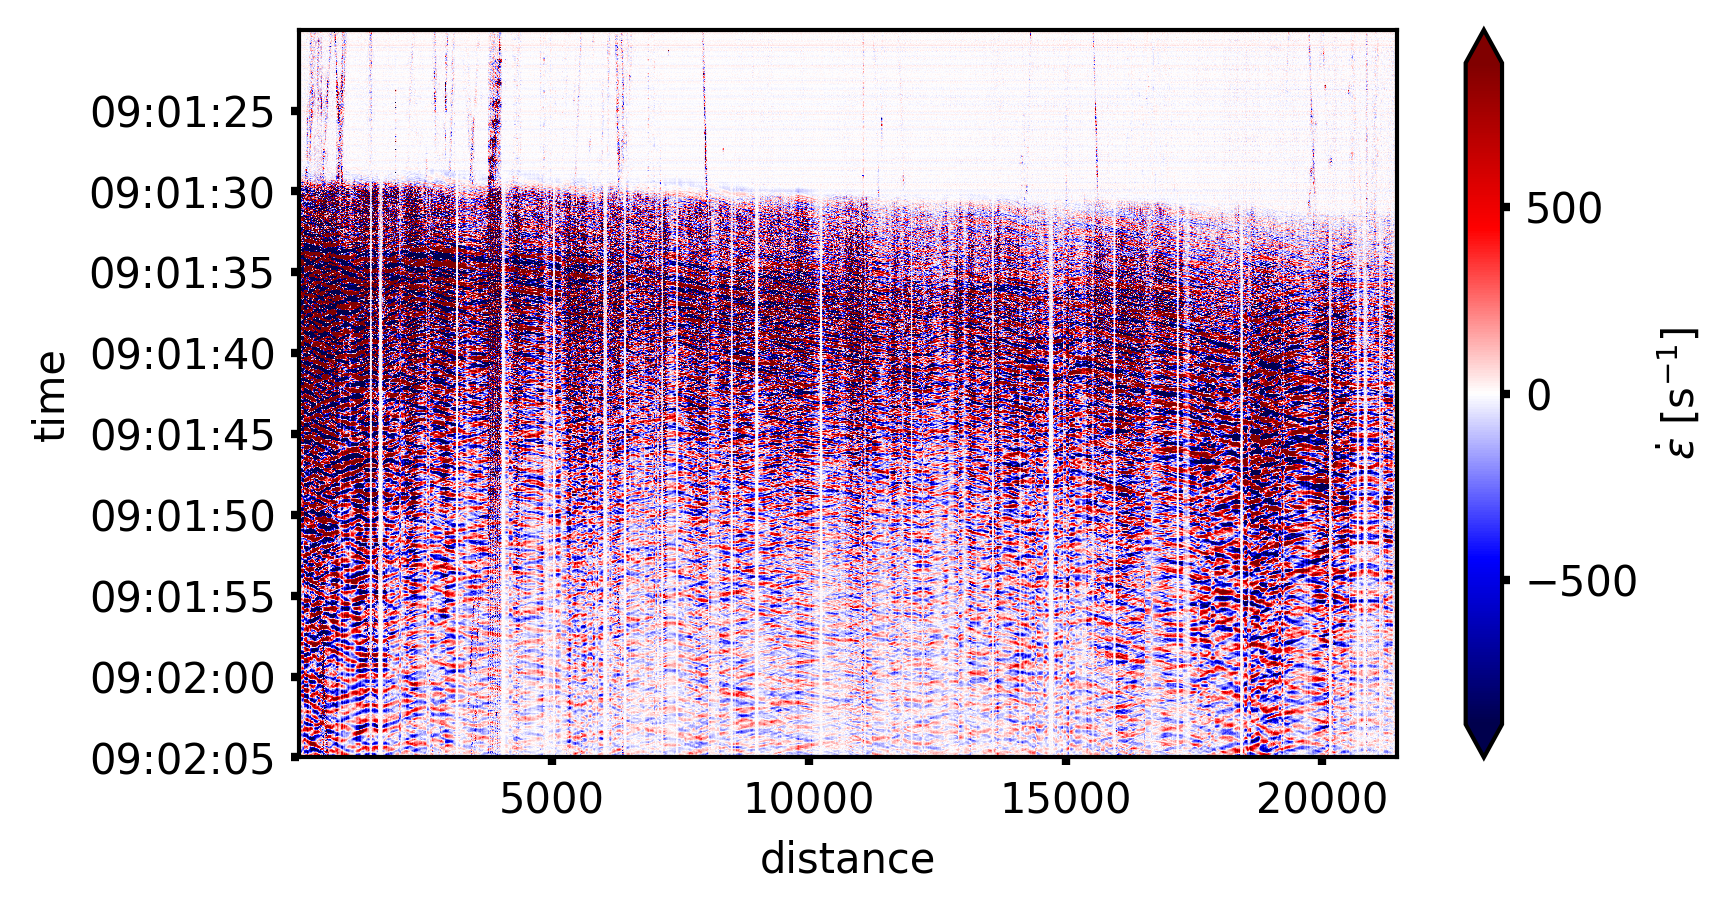

In [6]:
# Time selection (fmt "YYYY-MM-DDTHH:MM:SS.sss")
starttime = "2025-03-18T09:01:20.000"
endtime = "2025-03-18T09:02:05.000"
# Distance selection (in meters)
startdist = 60.0
enddist = 21450.0

da_sel = da.sel(
    time=slice(starttime, endtime),
    distance=slice(startdist, enddist),
)

# Plot
vlim = np.nanpercentile(np.abs(da_sel.values), 90)
fig, axes = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(150*mm, 80*mm),
    dpi=300
)
ax = axes
da_sel.plot(robust=True,
    yincrease=False,
    vmin=-vlim, vmax=vlim,
    ax=ax, 
    cmap="seismic", 
    cbar_kwargs={
        "label": r"$\dot{\varepsilon}$ [s$^{-1}$]",
    })
plt.show()

# Plot single traces very N receivers

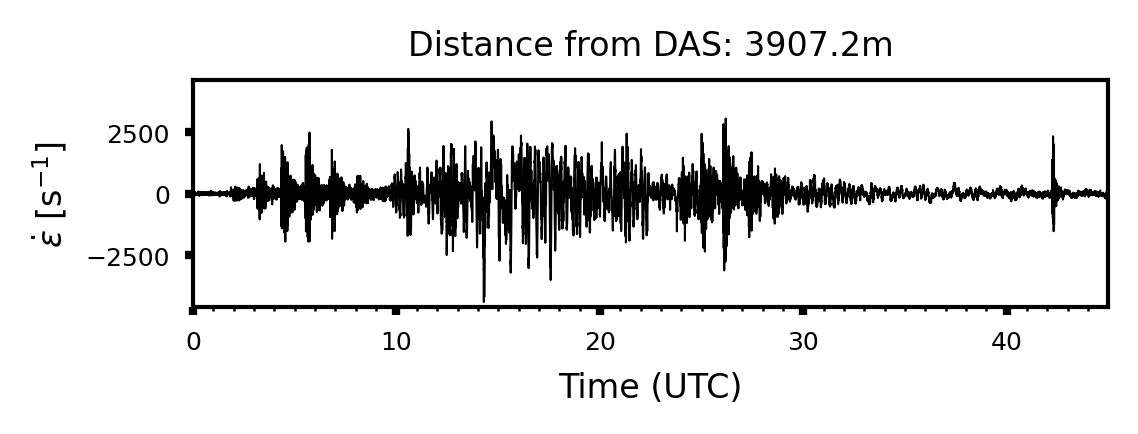

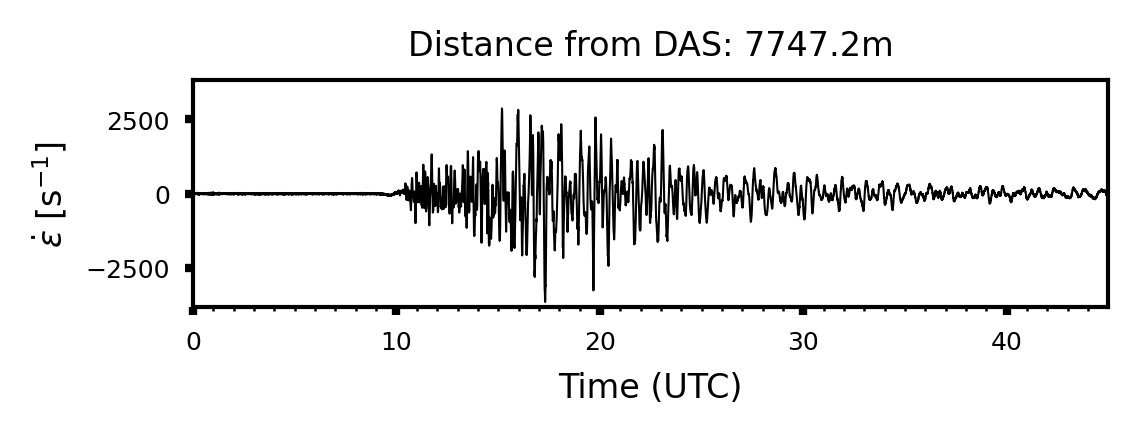

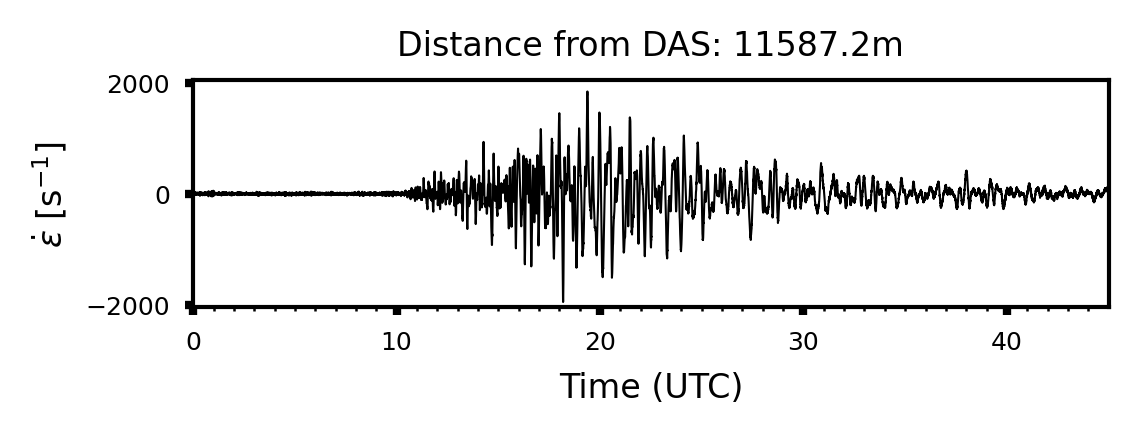

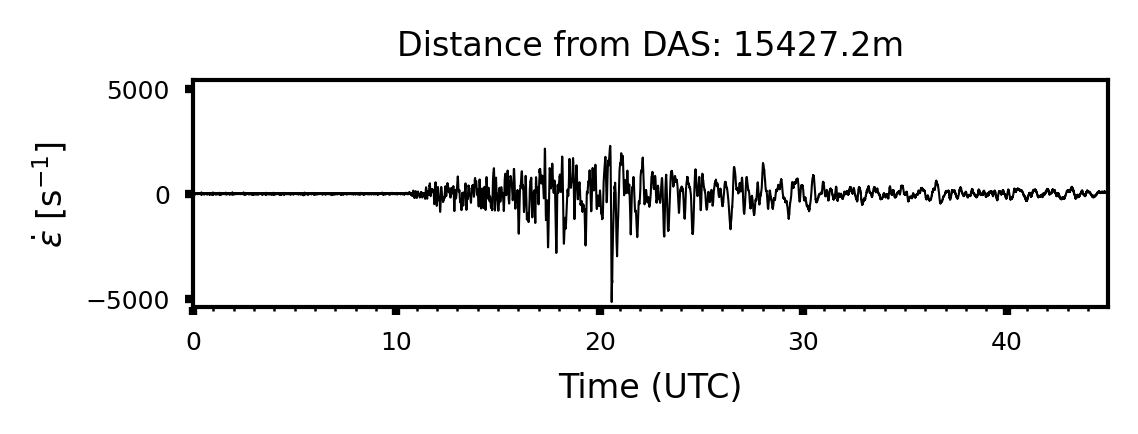

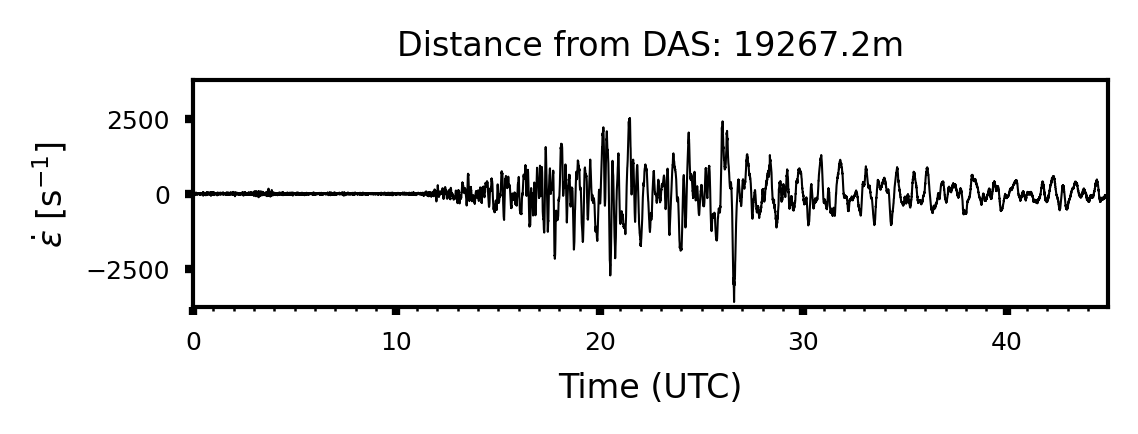

In [7]:
N = 400
for ch, dist in enumerate(da_sel["distance"]):
    if (ch % N == 0) & (ch != 0):
        trace = da_sel.isel(distance=ch)
        time_sec = (trace["time"].values - trace["time"].values[0]) / np.timedelta64(1, "s")
        maxamp = np.max(np.abs(trace.values))
        ylim = maxamp + maxamp * 0.05
        plt.figure(
            figsize=(100*mm, 25*mm),
        )
        plt.plot(time_sec, trace, "k", lw=0.5)
        plt.ylim([-ylim, ylim])
        plt.xlabel("Time (UTC)", fontsize=8)
        plt.ylabel(r"$\dot{\varepsilon}$ [s$^{-1}$]", fontsize=8)
        plt.title(f"Distance from DAS: {np.round(trace['distance'].values, 1)}m", fontsize=8)
        plt.xticks(fontsize=6)
        plt.yticks(fontsize=6)
        plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))
        plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
        plt.xlim([np.min(time_sec), np.max(time_sec)])
        plt.show()

# Filtering

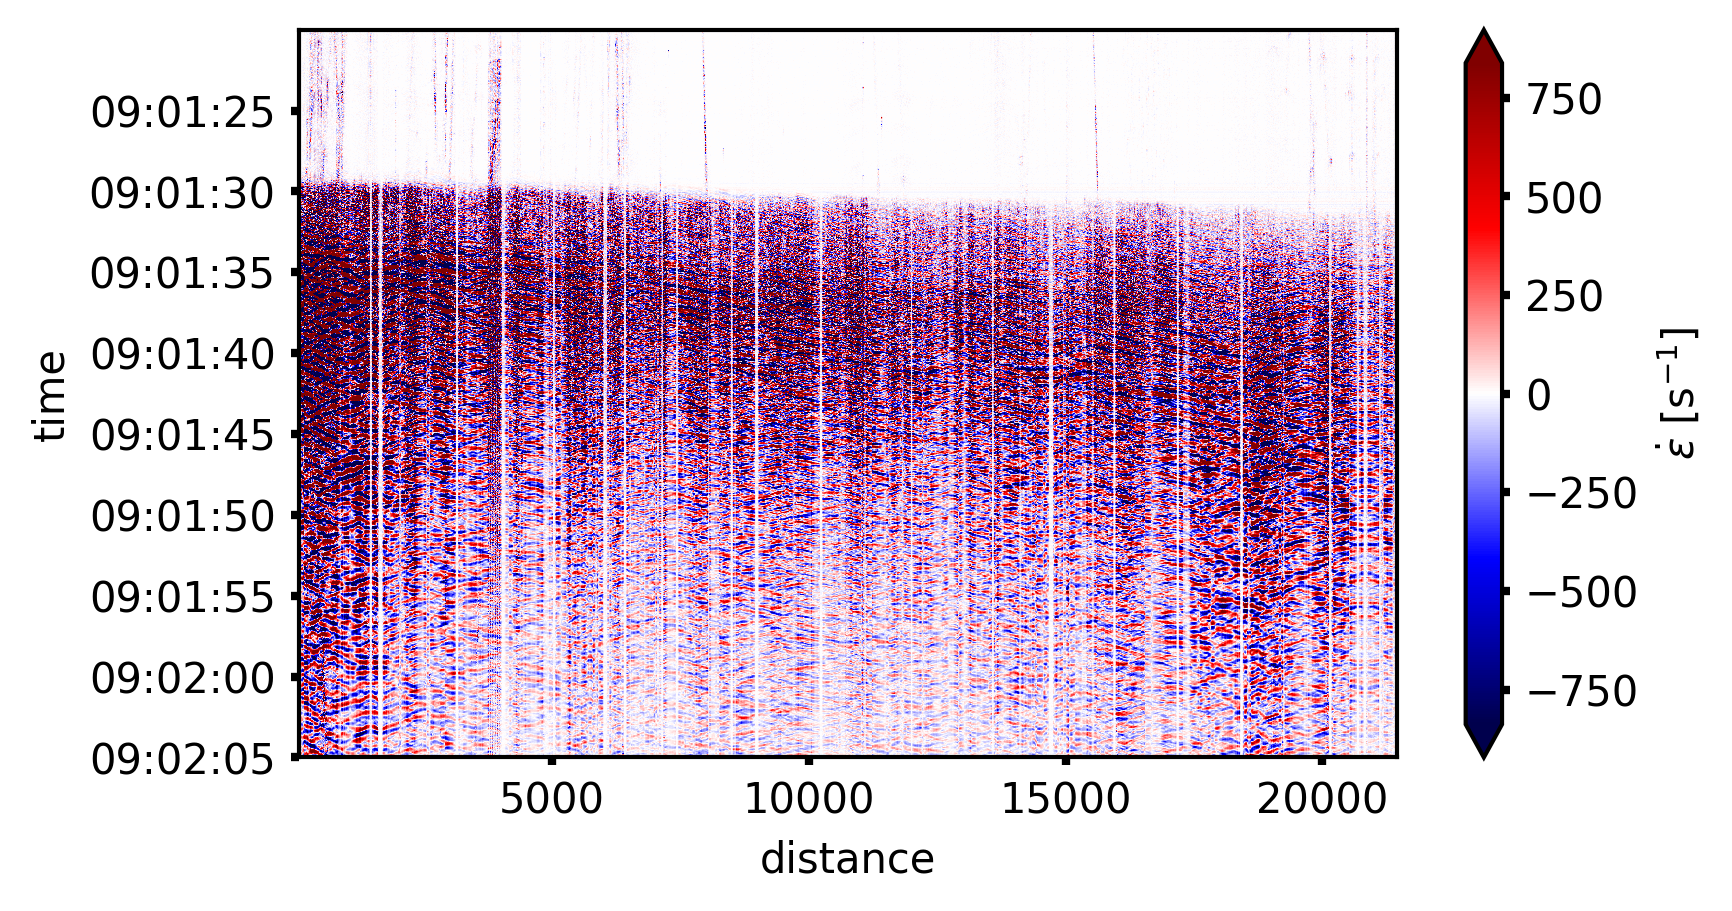

In [8]:
# Mean removal along space dimension
da_sel -= da_sel.mean("distance")
# Select band
lowcut, highcut = 1.0, 25.0

dt = xd.get_sampling_interval(da_sel, dim="time")
fs = 1 / dt
fN = fs / 2
bands = [lowcut / fN, highcut / fN]
b, a = sp.butter(4, bands, 'bandpass', analog=False)
da_fil = xd.signal.taper(da_sel, window=("tukey", 0.01), dim="time")
da_fil = xd.signal.lfilter(b, a, da_fil, dim="time")

# Plot
vlim = np.nanpercentile(np.abs(da_fil.values), 90)
fig, axes = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(150*mm, 80*mm),
    dpi=300
)
ax = axes
da_fil.plot(robust=True,
    yincrease=False,
    vmin=-vlim, vmax=vlim,
    ax=ax, 
    cmap="seismic", 
    cbar_kwargs={
        "label": r"$\dot{\varepsilon}$ [s$^{-1}$]",
    })
plt.show()

In [ ]:
import session_info
session_info.show()